In [1]:
import os
import sys
import warnings
from sklearn.metrics import mean_squared_error, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

data = pd.read_csv('bisnode_firms_clean2.csv')
df=pd.DataFrame(data)

In [2]:
df_wide = df.pivot(index='comp_id', columns='year', values='sales')
df_wide = df_wide.dropna(subset=[2012, 2014])
df_wide = df_wide[(df_wide[2012] > 0) & (df_wide[2014] > 0)]
valid_comp_ids = df_wide.index 

In [3]:
valid_comp_ids = df_wide.index
df2 = df[df['comp_id'].isin(valid_comp_ids)]
df2 = df[df['comp_id'].isin(valid_comp_ids)].copy()

In [4]:
df_2012 = df2[df2['year'] == 2012][['comp_id','sales']].rename(columns={'sales': 'sales_2012'})
df_2014 = df2[df2['year'] == 2014][['comp_id','sales']].rename(columns={'sales': 'sales_2014'})

df_merged = pd.merge(df_2012, df_2014, on='comp_id', how='inner')

In [5]:
df_merged['growth_rate'] = (df_merged['sales_2014'] - df_merged['sales_2012']) / df_merged['sales_2012']
q75 = df_merged['growth_rate'].quantile(0.75)
df_merged['fast_growth'] = (df_merged['growth_rate'] >= q75).astype(int)

In [6]:
df2 = pd.merge(df2, df_merged[['comp_id', 'fast_growth']], on='comp_id', how='left')

In [7]:
df_2012 = df2[df2['year'] == 2012].copy()

In [8]:
df_2012.describe()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,...,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq,fast_growth
count,14603.0,1.460300e+04,1.460300e+04,1.460300e+04,1.460300e+04,14603.000000,1.460300e+04,1.460300e+04,1.460300e+04,1.460300e+04,...,14603.000000,14603.000000,14603.000000,14603.000000,1.460300e+04,14603.000000,14603.000000,14603.000000,14603.000000,14603.000000
mean,2012.0,1.535013e+11,1.036150e+04,1.084479e+05,8.688942e+04,423.174095,1.793202e+03,1.365473e+03,1.654693e+05,1.069085e+04,...,0.009039,0.003972,0.124221,0.252551,1.062179e+01,0.022324,0.020407,-0.000463,0.231565,0.250017
std,0.0,1.379332e+11,5.106030e+04,4.301616e+05,3.111599e+05,7210.096048,3.672979e+04,3.586485e+04,1.190694e+06,1.029814e+05,...,0.094647,0.062899,0.329845,0.434490,9.461312e+00,0.147741,0.141392,0.481228,0.526019,0.433037
min,2012.0,1.001541e+06,-1.489630e+04,0.000000e+00,-8.759259e+03,-1418.518555,-1.740741e+02,-1.702444e+05,0.000000e+00,-1.984182e+06,...,0.000000,0.000000,0.000000,0.000000,2.074996e-07,0.000000,0.000000,-1.500000,0.000000,0.000000
25%,2012.0,2.910575e+10,2.296296e+02,4.550000e+03,4.035185e+03,0.000000,0.000000e+00,0.000000e+00,5.148148e+02,-4.833333e+03,...,0.000000,0.000000,0.000000,0.000000,3.254216e+00,0.000000,0.000000,-0.148274,0.001158,0.000000
50%,2012.0,1.147939e+11,1.262963e+03,1.455556e+04,1.567037e+04,0.000000,0.000000e+00,0.000000e+00,7.818519e+03,5.925926e+02,...,0.000000,0.000000,0.000000,0.000000,8.297208e+00,0.000000,0.000000,0.000000,0.022940,0.000000
75%,2012.0,2.563127e+11,5.261111e+03,5.076111e+04,5.301296e+04,0.000000,0.000000e+00,0.000000e+00,5.618704e+04,5.805555e+03,...,0.000000,0.000000,0.000000,1.000000,1.536874e+01,0.000000,0.000000,0.153557,0.146307,0.500000
max,2012.0,4.641050e+11,3.570863e+06,1.874527e+07,1.297067e+07,666300.000000,3.266667e+06,3.253704e+06,1.036673e+08,4.378226e+06,...,1.000000,1.000000,1.000000,1.000000,4.771708e+01,1.000000,1.000000,1.500000,2.250000,1.000000


In [9]:
all_predictors=['curr_assets', 'curr_liab', 'extra_exp', 'extra_inc', 'extra_profit_loss', 'fixed_assets', 'inc_bef_tax', 'intang_assets', 'inventories', 'liq_assets', 'material_exp', 'personnel_exp', 'profit_loss_year', 'sales', 'share_eq', 'subscribed_cap', 'total_assets_bs', 'fixed_assets_bs', 'liq_assets_bs', 'curr_assets_bs', 'share_eq_bs', 'subscribed_cap_bs', 'intang_assets_bs', 'extra_exp_pl', 'extra_inc_pl', 'extra_profit_loss_pl', 'inc_bef_tax_pl', 'inventories_pl', 'material_exp_pl', 'profit_loss_year_pl', 'personnel_exp_pl', 'balsheet_flag', 'balsheet_length', 'balsheet_notfullyear', 'female', 'ceo_age', 'flag_high_ceo_age', 'flag_low_ceo_age', 'flag_miss_ceo_age', 'ceo_count', 'foreign_management', 'age', 'age2', 'new']

In [10]:
all_predictors = list(dict.fromkeys(all_predictors))

In [11]:
print(all_predictors)

['curr_assets', 'curr_liab', 'extra_exp', 'extra_inc', 'extra_profit_loss', 'fixed_assets', 'inc_bef_tax', 'intang_assets', 'inventories', 'liq_assets', 'material_exp', 'personnel_exp', 'profit_loss_year', 'sales', 'share_eq', 'subscribed_cap', 'total_assets_bs', 'fixed_assets_bs', 'liq_assets_bs', 'curr_assets_bs', 'share_eq_bs', 'subscribed_cap_bs', 'intang_assets_bs', 'extra_exp_pl', 'extra_inc_pl', 'extra_profit_loss_pl', 'inc_bef_tax_pl', 'inventories_pl', 'material_exp_pl', 'profit_loss_year_pl', 'personnel_exp_pl', 'balsheet_flag', 'balsheet_length', 'balsheet_notfullyear', 'female', 'ceo_age', 'flag_high_ceo_age', 'flag_low_ceo_age', 'flag_miss_ceo_age', 'ceo_count', 'foreign_management', 'age', 'age2', 'new']


In [12]:
X = df_2012[all_predictors].copy()
y = df_2012['fast_growth']

In [13]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [15]:
logit_lasso = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=1.0, 
    random_state=42
)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

In [16]:
models = {
    'Lasso Logistic': (logit_lasso, X_train_scaled),
    'Random Forest': (rf, X_train),
    'XGBoost': (xgb, X_train)
}

In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [18]:
rmse_results = {model_name: [] for model_name in models.keys()}
auc_results = {model_name: [] for model_name in models.keys()}
loss_results = {model_name: [] for model_name in models.keys()}
threshold_results = {model_name: [] for model_name in models.keys()}

fold_names = []
fold = 1

thresholds = np.linspace(0, 1, 101)  # 0.00, 0.01, ..., 1.00

In [19]:
cost_fp = 2
cost_fn = 5

def expected_loss(y_true, y_prob, threshold, cost_fp, cost_fn):
    from sklearn.metrics import confusion_matrix
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (1, 1):
        if y_true.iloc[0] == 0:
            fp = 0
            fn = len(y_true)
        else:
            fp = len(y_true)
            fn = 0
    else:
        fp = cm[0, 1]
        fn = cm[1, 0]
    return cost_fp * fp + cost_fn * fn

In [20]:
for train_index, test_index in skf.split(X_train, y_train):
    fold_names.append(f'Fold {fold}')
    fold += 1
    
    for model_name, (model, X_model) in models.items():
        if isinstance(X_model, pd.DataFrame):
            X_fold_train = X_model.iloc[train_index]
            X_fold_test = X_model.iloc[test_index]
        else:
            X_fold_train = X_model[train_index]
            X_fold_test = X_model[test_index]
        
        y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]
        
        model.fit(X_fold_train, y_fold_train)
        
        y_prob = model.predict_proba(X_fold_test)[:, 1]
        
        rmse = np.sqrt(mean_squared_error(y_fold_test, y_prob))
        rmse_results[model_name].append(rmse)
        
        auc_val = roc_auc_score(y_fold_test, y_prob)
        auc_results[model_name].append(auc_val)
        
        losses = [expected_loss(y_fold_test, y_prob, t, cost_fp, cost_fn) for t in thresholds]
        best_idx = np.argmin(losses)
        best_loss = losses[best_idx]
        best_thresh = thresholds[best_idx]

        loss_results[model_name].append(best_loss)
        threshold_results[model_name].append(best_thresh)


In [21]:
rmse_df = pd.DataFrame(rmse_results, index=fold_names)
auc_df = pd.DataFrame(auc_results, index=fold_names)
loss_df = pd.DataFrame(loss_results, index=fold_names)
threshold_df = pd.DataFrame(threshold_results, index=fold_names)

In [22]:
rmse_df.loc['Mean'] = rmse_df.mean()
auc_df.loc['Mean'] = auc_df.mean()
loss_df.loc['Mean'] = loss_df.mean()
threshold_df.loc['Mean'] = threshold_df.mean()

In [23]:
print("Cross-Validated RMSE (on predicted probabilities):")
print(rmse_df)
print("\nCross-Validated AUC:")
print(auc_df)
print("\nCross-Validated Expected Loss:")
print(loss_df)
print("\nCross-Validated Best Thresholds (for minimal loss):")
print(threshold_df)

Cross-Validated RMSE (on predicted probabilities):
        Lasso Logistic  Random Forest   XGBoost
Fold 1        0.402619       0.402528  0.416202
Fold 2        0.411830       0.402406  0.415253
Fold 3        0.408192       0.405688  0.423503
Fold 4        0.407717       0.401057  0.419062
Fold 5        0.411095       0.406021  0.421719
Mean          0.408291       0.403540  0.419148

Cross-Validated AUC:
        Lasso Logistic  Random Forest   XGBoost
Fold 1        0.694502       0.702504  0.680927
Fold 2        0.680775       0.708842  0.699742
Fold 3        0.686879       0.695275  0.672853
Fold 4        0.698786       0.721573  0.686748
Fold 5        0.685180       0.698140  0.687515
Mean          0.689224       0.705267  0.685557

Cross-Validated Expected Loss:
        Lasso Logistic  Random Forest  XGBoost
Fold 1          2189.0         2175.0   2279.0
Fold 2          2263.0         2170.0   2248.0
Fold 3          2281.0         2168.0   2312.0
Fold 4          2148.0         2132

In [24]:
avg_loss = loss_df.loc['Mean']
best_model = avg_loss.idxmin()
print(f"\nBest model is: {best_model}, with an average expected loss of {avg_loss[best_model]:.2f}")


Best model is: Random Forest, with an average expected loss of 2165.80


In [25]:
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

y_prob_rf = rf.predict_proba(X_holdout)[:, 1]
y_prob_xgb = xgb.predict_proba(X_holdout)[:, 1]

In [26]:
best_threshold_rf=0.432
best_threshold_xgb=0.322

y_pred_rf = (y_prob_rf >= best_threshold_rf).astype(int)
y_pred_xgb = (y_prob_xgb >= best_threshold_xgb).astype(int)

In [27]:
cm_rf = confusion_matrix(y_holdout, y_pred_rf)
cm_xgb = confusion_matrix(y_holdout, y_pred_xgb)

In [28]:
print("Random Forest Confusion Matrix (Holdout):\n", cm_rf)
print("Random Forest Classification Report (Holdout):")
print(classification_report(y_holdout, y_pred_rf))

Random Forest Confusion Matrix (Holdout):
 [[2030  161]
 [ 489  241]]
Random Forest Classification Report (Holdout):
              precision    recall  f1-score   support

           0       0.81      0.93      0.86      2191
           1       0.60      0.33      0.43       730

    accuracy                           0.78      2921
   macro avg       0.70      0.63      0.64      2921
weighted avg       0.75      0.78      0.75      2921



In [29]:
print("\nXGBoost Confusion Matrix (Holdout):\n", cm_xgb)
print("XGBoost Classification Report (Holdout):")
print(classification_report(y_holdout, y_pred_xgb))


XGBoost Confusion Matrix (Holdout):
 [[1801  390]
 [ 400  330]]
XGBoost Classification Report (Holdout):
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      2191
           1       0.46      0.45      0.46       730

    accuracy                           0.73      2921
   macro avg       0.64      0.64      0.64      2921
weighted avg       0.73      0.73      0.73      2921



In [30]:
fpr_rf, tpr_rf, _ = roc_curve(y_holdout, y_prob_rf)
auc_rf = roc_auc_score(y_holdout, y_prob_rf)

In [31]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_holdout, y_prob_xgb)
auc_xgb = roc_auc_score(y_holdout, y_prob_xgb)

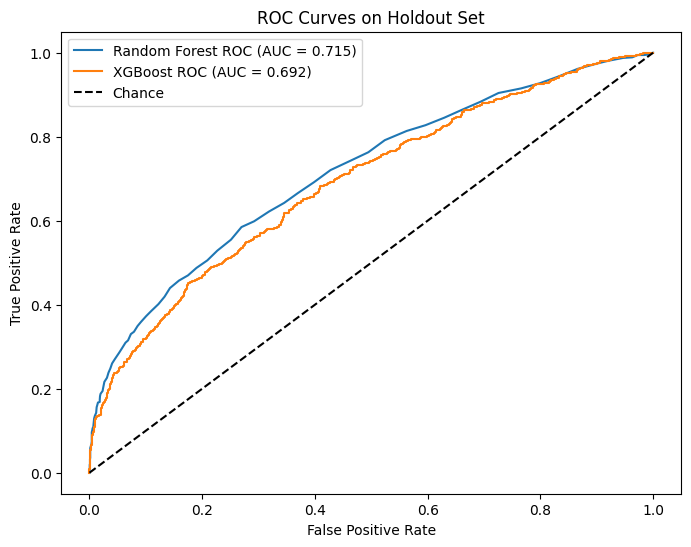

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest ROC (AUC = {auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost ROC (AUC = {auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves on Holdout Set')
plt.legend()
plt.show()

In [33]:
importances = rf.feature_importances_

In [34]:
if isinstance(X_train, pd.DataFrame):
    feature_names = X_train.columns
else:
    feature_names = all_predictors

In [35]:
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

In [36]:
filtered_importance_df = importance_df[importance_df['importance'] >= 0.02]

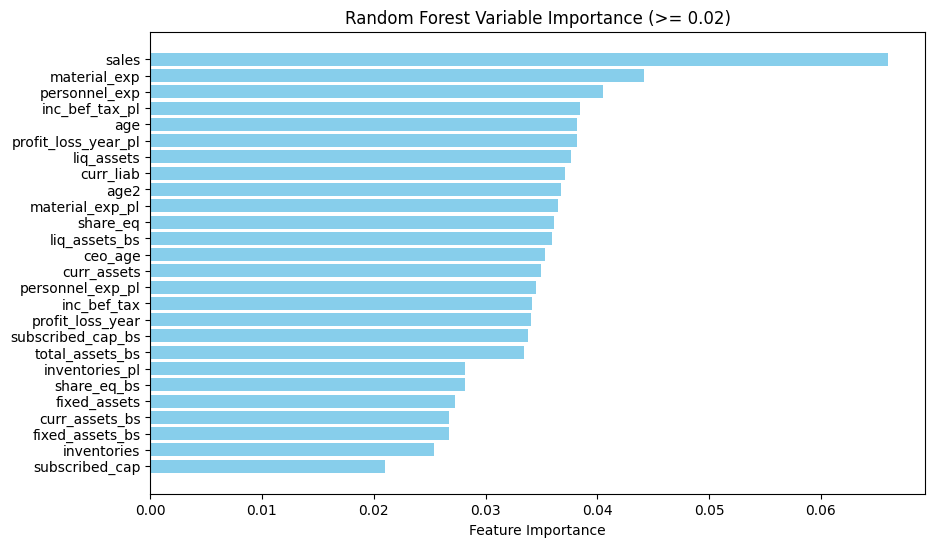

In [37]:
plt.figure(figsize=(10, 6))
plt.barh(filtered_importance_df['feature'], filtered_importance_df['importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel('Feature Importance')
plt.title('Random Forest Variable Importance (>= 0.02)')
plt.show()